#นาย ปพนธ์ ชุณหคล้าย 6210503691

# Spark dataframes on HDFS

New York City Taxi Cab Trip

We look at [the New York City Taxi Cab dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml). This includes every ride made in the city of New York since 2009.

On [this website](http://chriswhong.github.io/nyctaxi/) you can see the data for one random NYC yellow taxi on a single day.

On [this post](http://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/), you can see an analysis of this dataset. Postgres and R scripts are available on [GitHub](https://github.com/toddwschneider/nyc-taxi-data).

## Loading the data

Normally we would read and load this data into memory as a Pandas dataframe.  However in this case that would be unwise because this data is too large to fit in RAM.

The data can stay in the hdfs filesystem but for performance reason we can't use the csv format. The file is large (32Go) and text formatted. Data Access is very slow.

You can convert csv file to parquet with Spark.

In [ ]:
!wget https://www.cpe.ku.ac.th/~cnc/download/yellow_tripdata_2016-01.csv.gz -O yellow_tripdata_2016-01.csv.gz 

--2022-09-07 23:09:48--  https://www.cpe.ku.ac.th/~cnc/download/yellow_tripdata_2016-01.csv.gz
Resolving www.cpe.ku.ac.th (www.cpe.ku.ac.th)... 158.108.32.150
Connecting to www.cpe.ku.ac.th (www.cpe.ku.ac.th)|158.108.32.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 431451101 (411M) [application/octet-stream]
Saving to: ‘yellow_tripdata_2016-01.csv.gz’

yellow_tripdata_201 100%[===================>] 411.46M   101MB/s    in 4.1s    

2022-09-07 23:09:52 (101 MB/s) - ‘yellow_tripdata_2016-01.csv.gz’ saved [431451101/431451101]



In [ ]:
!gzip -d yellow_tripdata_2016-01.csv.gz 

In [ ]:
%%time 
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("Convert CSV to parquet")      \
        .getOrCreate()



CPU times: user 2.86 ms, sys: 639 µs, total: 3.5 ms
Wall time: 45 ms


In [ ]:
#code to copy to hdfs
! hdfs dfs -rm /yellow_tripdata_2016-01.csv
! hdfs dfs -copyFromLocal yellow_tripdata_2016-01.csv /

2022-09-07 23:40:35,164 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `/yellow_tripdata_2016-01.csv': No such file or directory
2022-09-07 23:40:37,186 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2022-09-07 23:40:38,374 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2022-09-07 23:40:39,460 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2022-09-07 23:40:40,106 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2022-09-07 23:40:40,900 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2022-09-07 23:40:41,672 INFO sasl.SaslDataTransferClient: SASL encryption 

In [ ]:
df = spark.read.csv("hdfs://localhost:9000/yellow_tripdata_2016-01.csv", 
                    header="true",inferSchema="true")

In [ ]:
df.write.parquet("hdfs://localhost:9000/yellow_tripdata_2016-01.parquet")

spark.stop()

In [ ]:
spark.stop()

## Spark Cluster

A Spark cluster is available and described on this [web interface](http://svmass2.mass.uhb.fr:8080)

![](https://github.com/pnavaro/big-data/blob/master/notebooks/images/cluster-overview.png?raw=1)

```py
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .getOrCreate()
spark
```

The SparkSession is connected to the Spark’s own standalone cluster manager (It is also possible to use YARN). The manager allocate resources across applications. Once connected, Spark acquires executors on nodes in the cluster, which are processes that run computations and store data for your application. Next, it sends your application code (Python file) to the executors. Finally, tasks are sent to the executors to run.

Spark can access to files located on hdfs and it is also possible to access to local files. Example:

```py
df = spark.read.parquet('file:///home/navaro_p/nyc-taxi/2016.parquet')
```

### Exercise

- Pick a year and read and convert csv files to parquet in your hdfs homedirectory.
- **Don't run the python code inside a notebook cell**. Save a python script and launch it from a terminal instead.
In Jupyter notebook you won't see any progress or information if error occurs.
- Use the [`spark-submit`](https://spark.apache.org/docs/latest/submitting-applications.html) command shell to run your script on the cluster.
- You can control the log with 
```py
spark.sparkContext.setLogLevel('ERROR')
```
Valid log levels include: ALL, DEBUG, ERROR, FATAL, INFO, OFF, TRACE, WARN

**Try your script with a single file before to do it for a whole year.**

**Read carefully the script given above, don't submit it as is. You have to change some
part of this code**

## Some examples that can be run on the cluster

- Here we read the NYC taxi data files of year 2016 and select some variables.

```py
columns = ['tpep_pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'tip_amount', 'total_amount']

df = (spark.read.parquet('hdfs://svmass2.mass.uhb.fr:54310/user/navaro/nyc-taxi/2016.parquet').select(*columns))
```

- Sum the total number of passengers
```py
df.agg({'passenger_count': 'sum'}).collect()
```

- Average number of passenger per trip`
```py
df.agg({'passenger_count': 'avg'}).collect()
```

- How many trip with 0,1,2,3,...,9 passenger`
```py
df.groupby('passenger_count').agg({'*': 'count'}).collect()
```

## Exercises

How well people tip based on the number of passengers in a cab.  To do this you have to:

1.  Remove rides with zero fare
2.  Add a new column `tip_fraction` that is equal to the ratio of the tip to the fare
3.  Group by the `passenger_count` column and take the mean of the `tip_fraction` column.

### Cheat Sheets and documentation

- [Spark DataFrames in Python](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PySpark_SQL_Cheat_Sheet_Python.pdf)
- [Spark in Python](http://datacamp-community.s3.amazonaws.com/4d91fcbc-820d-4ae2-891b-f7a436ebefd4)
-  https://spark.apache.org/docs/latest/api/python/pyspark.sql.html

Use the [PySpark API](https://spark.apache.org/docs/latest/api/python/index.html).

- **Write a python program and use `spark-submit`**
- **Read the parquet files instead of csv files** 
- **Don't forget spark.stop() at the end of the script**

## Hints

- How to remove rows
```python
df = df.filter(df.name == 'expression')
```

- How to make new columns
```python
df = df.withColumn('var2', df.var0 + df.var1)
```

- How to do groupby-aggregations
```python
df.groupBy(df.name).agg({'column-name': 'avg'})
```

When you want to collect the result of your computation, finish with the `.collect()` method.

### Exercises 

1. Plot the tip as a function of the hour of day and the day of the week?
2. Investigate the `payment_type` column.  See how well each of the payment types correlate with the `tip_fraction`.  Did you find anything interesting?  Any guesses on what the different payment types might be?  If you're interested you may be able to find more information on the [NYC TLC's website](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml)
3. Plot the average of the new column tip_fraction grouped by day of week.
4. Plot the average of the new column tip_fraction grouped by hour of day.

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .getOrCreate()

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import date_format
from pyspark.sql.functions import col
%matplotlib inline 

In [ ]:
df = spark.read.parquet("hdfs://localhost:9000/yellow_tripdata_2016-01.parquet",header="true",inferSchema="true")

In [ ]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RatecodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       2| 2016-01-03 17:09:11|  2016-01-03 17:21:18|              6|         2.13|-73.98211669921875| 40.73194885253906|         1|    

#1.Plot the tip as a function of the hour of the day and the day of the week?

In [ ]:
from pyspark.sql.functions import hour

df = df.withColumn("days", date_format(col("tpep_pickup_datetime"), "EEEE"))
df = df.withColumn("hours", hour(col("tpep_pickup_datetime")))

Text(0, 0.5, 'Tip')

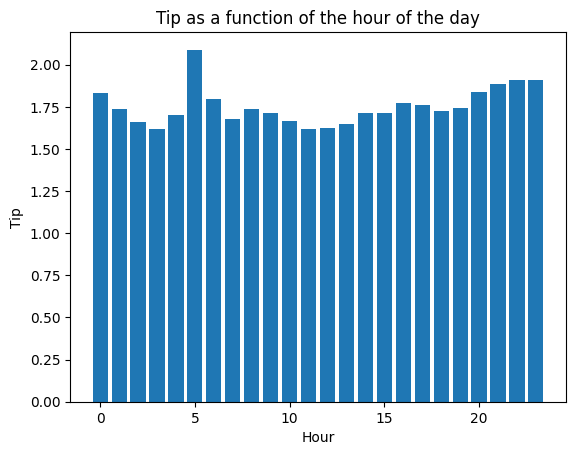

In [ ]:
df_hours = df.groupby('hours').agg({"tip_amount": "avg"})

plt.bar(
    df_hours.toPandas()['hours'].values.tolist(),
    df_hours.toPandas()['avg(tip_amount)'].values.tolist()
)
plt.title('Tip as a function of the hour of the day')
plt.xlabel("Hour")
plt.ylabel("Tip")

Text(0, 0.5, 'Tip')

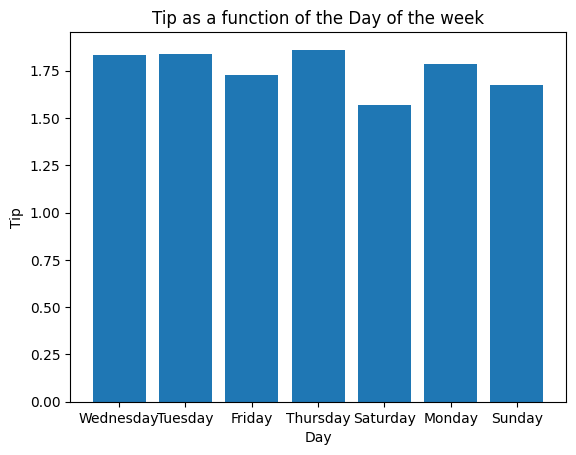

In [ ]:
df_day_of_week = df.groupby('days').agg({'tip_amount': 'avg'})

plt.bar(
    df_day_of_week.toPandas()['days'].values.tolist(),
    df_day_of_week.toPandas()['avg(tip_amount)'].values.tolist()
)
plt.title('Tip as a function of the Day of the week')
plt.xlabel("Day")
plt.ylabel("Tip")

#2.Investigate the payment_type column. See how well each of the payment types correlate with the tip_fraction. Did you find anything interesting? Any guesses on what the different payment types might be? If you're interested you may be able to find more information on the NYC TLC's website

In [ ]:
# เอาเฉพาะกรณีค่าโดยสารมากกว่า 0 
df = df.filter(df.fare_amount > 0)

# สร้าง column tip_fraction โดยการเอา tip_amount หารด้วย fare_amount
df = df.withColumn("tip_fraction", df.tip_amount /df.fare_amount)

In [ ]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+------+-----+-------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RatecodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|  days|hours|       tip_fraction|
+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+------+-----+-------------------+
|       2| 2016-01-03 17:09:11|  2016

In [ ]:
df_group = df.groupby('payment_type').agg({'tip_fraction': 'avg'})
df_group.show()

+------------+--------------------+
|payment_type|   avg(tip_fraction)|
+------------+--------------------+
|           1| 0.23870141823237997|
|           3|0.005179429048964...|
|           4|2.723797873366249E-4|
|           2|5.274088303727959E-6|
|           5|                 0.0|
+------------+--------------------+



ได้ payment_type ออกมา 5 แบบดังนี้

-แบบที่ 1 จ่ายอัตราส่วน Tip ต่อ ค่าโดยสารเฉลี่ยอยู่ที่ 0.2387

-แบบที่ 2 จ่ายอัตราส่วน Tip ต่อ ค่าโดยสารเฉลี่ยอยู่ที่ 0.0052

-แบบที่ 3 จ่ายอัตราส่วน Tip ต่อ ค่าโดยสารเฉลี่ยอยู่ที่ 2.7238*10^-4

-แบบที่ 4 จ่ายอัตราส่วน Tip ต่อ ค่าโดยสารเฉลี่ยอยู่ที่ 5.2741*10^-6

-แบบที่ 5 จ่ายอัตราส่วน Tip ต่อ ค่าโดยสารเฉลี่ยอยู่ที่ 0


#3.Plot the average of the new column tip_fraction grouped by day of week.

Text(0, 0.5, 'tip_fraction')

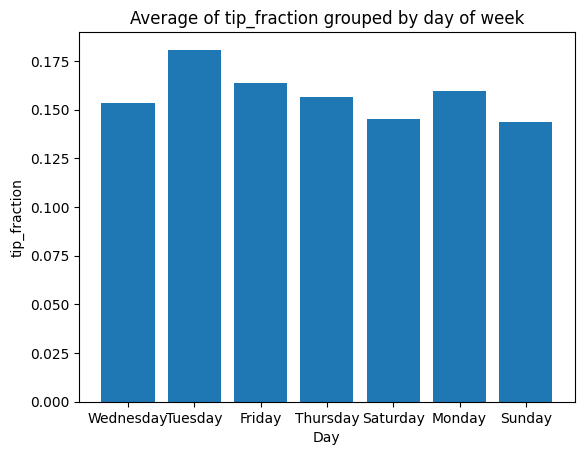

In [ ]:
df_day_tip_fraction = df.groupby('days').agg({'tip_fraction': 'avg'})

plt.bar(
    df_day_tip_fraction.toPandas()['days'].values.tolist(),
    df_day_tip_fraction.toPandas()['avg(tip_fraction)'].values.tolist()
)
plt.title('Average of tip_fraction grouped by day of week')
plt.xlabel("Day")
plt.ylabel("tip_fraction")

#4.Plot the average of the new column tip_fraction grouped by hour of day.

Text(0, 0.5, 'tip_fraction')

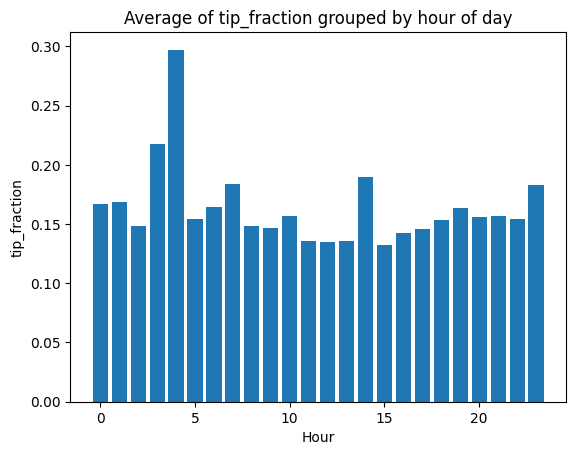

In [ ]:
df_hour_tip_fraction = df.groupby('hours').agg({'tip_fraction': 'avg'})

plt.bar(
    df_hour_tip_fraction.toPandas()['hours'].values.tolist(),
    df_hour_tip_fraction.toPandas()['avg(tip_fraction)'].values.tolist()
)
plt.title('Average of tip_fraction grouped by hour of day')
plt.xlabel("Hour")
plt.ylabel("tip_fraction")